<a href="https://colab.research.google.com/github/fvicencioh/FEM/blob/main/Tarea%204/Tarea_4_FEM_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de dependencias

In [ ]:
#!apt-get update -qq
#!apt-get install -y libglu1-mesa libxi-dev libxmu-dev libglu1-mesa-dev
#!pip install --upgrade gmsh
!pip install --upgrade meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 4.3 MB/s eta 0:00:00


# Script para pasar las coordenadas del archivo csv a un formato legible por gmsh

In [ ]:
import csv
import numpy as np

with open('n63412-il.csv') as csv_file:
  f = csv.reader(csv_file, delimiter=',')
  points = {}
  lines = {}
  surfaces = {}
  dummy = []
  counter = 1
  header = False
  for line in f:
    if line[0] == 'Chord(mm)':
      chord = line[1] # Ancho del perfil
    if line[0] == 'Radius(mm)':
      radius = line[1] # Curvatura del perfil
    if line[0] == 'Pitch(deg)':
      pitch = line[1] # Ángulo de ataque
    if not header and line[0] == 'Airfoil surface':
      header = True
    if line[0]=='':
      header=False
    if header and line[0]!='X(mm)' and line[0]!='Airfoil surface':
      if line not in points.values():
        points[counter] = line
        x_temp = float(line[0])
        y_temp = float(line[1])
        dummy.append([x_temp, y_temp])
        counter+=1
  airfoil_points = np.zeros((len(dummy),2))
  airfoil_points[:,:] = dummy
  internal_points = counter-1

#-----------------Definición de caja externa-----------------------#

points[counter] = [str(-2*float(chord)), str(float(chord))] # Esquina superior izquierda
points[counter+1] = [str(-2*float(chord)), str(-float(chord))] # Esquina inferior izquierda
points[counter+2] = [str(5*float(chord)), str(-float(chord))] # Esquina inferior derecha
points[counter+3] = [str(5*float(chord)), str(float(chord))] #Esquina superior derecha

for i in range(1,internal_points+1):
  if i==internal_points:
    lines[i] = [str(i),'1']
  else:
    lines[i] = [str(i), str(i+1)]

internal_lines = len(lines)
lines[internal_lines+1] = [str(counter), str(counter+1)] # In
lines[internal_lines+2] = [str(counter+1), str(counter+2)] # Bottom
lines[internal_lines+3] = [str(counter+2), str(counter+3)] # Out
lines[internal_lines+4] = [str(counter+3), str(counter)] # Top

lines_numbers = []
for i in lines.keys():
  lines_numbers.append(str(i))

surfaces['1'] = lines_numbers[:internal_lines]
surfaces['2'] = lines_numbers[internal_lines:] # Rectangulo Externo

md = input('Mesh Density = ')
mdr = input('Refinated mesh density = ')
filename = 'Chord_'+chord+'_radius_'+radius+'_pitch_'+pitch+'_md_'+md+'_'+mdr+'.geo'
with open(filename, 'w') as mesh_file:
  mesh_file.write('md = '+md+';\n')
  mesh_file.write('mdr = '+mdr+';\n')
  mesh_file.write('\n')
  for i in points:
    if i<=internal_points:
      mesh_file.write('Point('+str(i)+')={'+points[i][0]+', '+points[i][1]+', 0, mdr};\n')
    else:
      mesh_file.write('Point('+str(i)+')={'+points[i][0]+', '+points[i][1]+', 0, md};\n')
  mesh_file.write('\n')
  for i in lines:
    mesh_file.write('Line('+str(i)+')={'+lines[i][0]+', '+lines[i][1]+'};\n')
  mesh_file.write('\n')
  surface_line = ', '.join(surfaces['1'])
  mesh_file.write('Curve Loop(1) = {'+surface_line+'};\n')
  surface_line = ', '.join(surfaces['2'])
  mesh_file.write('Curve Loop(2) = {'+surface_line+'};\n')
  mesh_file.write('\n')
  mesh_file.write('Plane Surface(1) = {1, 2};\n')
  mesh_file.write('\n')
  surface_line = ', '.join(surfaces['1'])
  mesh_file.write('Physical Line("airfoil") = {'+surface_line+'};\n')
  mesh_file.write('Physical Line("in") = {'+str(internal_lines+1)+'};\n')
  mesh_file.write('Physical Line("bottom") = {'+str(internal_lines+2)+'};\n')
  mesh_file.write('Physical Line("out") = {'+str(internal_lines+3)+'};\n')
  mesh_file.write('Physical Line("top") = {'+str(internal_lines+4)+'};\n')
  mesh_file.write('Physical Surface("Canal") = {1};\n')
  mesh_file.write('\n')
  mesh_file.write('Mesh 2;\n')
  mesh_file.write('\n')
  mesh_file.write('Mesh.SurfaceFaces = 1;\n')
  mesh_file.write('Mesh.points = 1;\n')
  mesh_file.write('Mesh.saveAll = 1;\n')
  mesh_file.write('Mesh.SaveGroupsOfElements = 1;\n')
  mesh_file.write('\n')
  mesh_file.write('Save "malla.msh"\n')
print(f'The Gmsh file {filename} was created using: Chord = {chord} [mm], Radius = {radius} [mm], Pitch = {pitch} [deg], md = {md} and mdr = {mdr} for airfoil')

# Desarrollo de la tarea 4

In [ ]:
#import gmsh
#gmsh.initialize()
#gmsh.finalize()
#print("Gmsh importado correctamente")

In [ ]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata, interp1d
from matplotlib.collections import PolyCollection

class system_2D:
  def __init__(self, mesh):
    self.mesh = meshio.read(mesh)
    self.nodes = self.mesh.points
    self.triangles = self.mesh.cells_dict['triangle']
    self.lines = self.mesh.cells_dict['line']
    self.n_nodes = len(self.nodes)
    self.n_triangles = len(self.triangles)
    self.n_lines = len(self.lines)
    print('Mesh imported correctly')
    print(f'Number of nodes: {self.n_nodes}.')
    print(f'Number of elements: {self.n_triangles}.')

  def define_physical_groups(self):
    self.airfoil_edges = []
    self.inlet_edges = []
    self.bottom_edges = []
    self.outlet_edges = []
    self.top_edges = []

    for cb, phys in zip(self.mesh.cells, self.mesh.cell_data["gmsh:physical"]):
        if cb.type != "line":
            continue

        if phys[0] == 1:
            self.airfoil_edges.append(cb.data)
        elif phys[0] == 2:
            self.inlet_edges.append(cb.data)
        elif phys[0] == 3:
            self.bottom_edges.append(cb.data)
        elif phys[0] == 4:
            self.outlet_edges.append(cb.data)
        elif phys[0] == 5:
            self.top_edges.append(cb.data)

    def set_edges(edge):
      if len(edge) == 0:
        return set()
      vsta = np.vstack(edge)
      return set((int((min(a,b))), int(max(a,b))) for a,b in vsta)

    self.airfoil_edges_a = np.vstack(self.airfoil_edges)
    self.inlet_edges_a = np.vstack(self.inlet_edges)
    self.bottom_edges_a = np.vstack(self.bottom_edges)
    self.outlet_edges_a = np.vstack(self.outlet_edges)
    self.top_edges_a = np.vstack(self.top_edges)

    self.airfoil_edges = set_edges(self.airfoil_edges)
    self.inlet_edges   = set_edges(self.inlet_edges)
    self.bottom_edges  = set_edges(self.bottom_edges)
    self.outlet_edges  = set_edges(self.outlet_edges)
    self.top_edges     = set_edges(self.top_edges)

  def solve_system(self, U_inf = 1):
    self.set_limits()
    self.define_physical_groups()
    self.identify_airfoil_points()
    self.assemble_K_general()
    self.rhs(U_inlet = U_inf, U_outlet = U_inf)
    self.set_potential()
    self.phi = np.linalg.solve(self.Kg, self.FV)
    self.compute_v_and_p(U=U_inf)
    self.compute_centroid()
    self.compute_lift(U=U_inf)

  def compute_centroid(self):
    self.centroid_matrix = np.zeros((self.n_triangles,2))
    self.phi_centroid = np.zeros((self.n_triangles))
    for i in range(self.n_triangles):
      p1,p2,p3 = self.triangles[i]
      x_mean = np.mean(np.array([self.nodes[p1,0],self.nodes[p2,0],self.nodes[p3,0]]))
      y_mean = np.mean(np.array([self.nodes[p1,1],self.nodes[p2,1],self.nodes[p3,1]]))
      self.centroid_matrix[i,:] = np.array([x_mean, y_mean])
      self.phi_centroid[i] = np.mean(np.array([self.phi[p1], self.phi[p2], self.phi[p3]]))

  def compute_v_and_p(self, U):
    self.gradphi = np.zeros((self.n_triangles, 2))
    self.velocity = np.zeros(self.n_triangles)
    self.pressure = np.zeros(self.n_triangles)
    for i in range(self.n_triangles):
      self.gradphi[i,:] = self.compute_phigrad(i)
      self.velocity[i] = np.linalg.norm(self.gradphi[i,:])
      self.pressure[i] = 1 - np.dot(self.gradphi[i], self.gradphi[i])/(U**2)

  def assemble_K_general(self):
    self.Kg = np.zeros((self.n_nodes, self.n_nodes))

    for i in range(self.n_triangles):
      Ke, D_J = self.compute_K(i)
      if D_J>0:
        p1, p2, p3 = self.triangles[i]

        self.Kg[p1, p1]+= Ke[0,0]
        self.Kg[p1, p2]+= Ke[0,1]
        self.Kg[p1, p3]+= Ke[0,2]

        self.Kg[p2, p1]+= Ke[1,0]
        self.Kg[p2, p2]+= Ke[1,1]
        self.Kg[p2, p3]+= Ke[1,2]

        self.Kg[p3, p1]+= Ke[2,0]
        self.Kg[p3, p2]+= Ke[2,1]
        self.Kg[p3, p3]+= Ke[2,2]
      else:
        raise ValueError('Singular Jacobian Matrix')

  def rhs(self, U_inlet=1, U_outlet=1):
    self.FV = np.zeros(self.n_nodes)
    #------------------- Fijar condición de Neumann en la entrada y salida-----------------------#
    N = np.array([0.5, 0.5]) # Funciones de forma en el borde
    for i in range(self.n_lines):
      p1, p2= self.lines[i]
      b,l,o = self.is_boundary(self.lines[i])
      LB = np.linalg.norm(self.nodes[p2][:2] - self.nodes[p1][:2])
      if b:
        continue
      if l:
        n_unit = self.compute_normal(self.lines[i])
        u_normal = U_inlet * np.dot(n_unit, np.array([1, 0])) #1 o -1 * U
        self.FV[p1]+= LB * u_normal * N[0] # El /2 esta incluido en N
        self.FV[p2]+= LB * u_normal * N[1]
      if o:
        n_unit = self.compute_normal(self.lines[i])
        u_normal = U_outlet * np.dot(n_unit, np.array([1, 0])) #1 o -1 * U
        self.FV[p1]+= LB * u_normal * N[0]
        self.FV[p2]+= LB * u_normal * N[1]

  def set_potential(self):
    #------------------- Fijar el valor del potencial en un nodo para evitar singularidad -----------------------#
    p1 = self.outlet_edges_a[0][0]
    self.Kg[:,p1] = 0
    self.Kg[p1,:] = 0
    self.Kg[p1,p1] = 1
    self.FV[p1] = 0

  def is_boundary(self, line):
    p1, p2 = line
    p1 = int(p1)
    p2 = int(p2)
    norm = (min(p1, p2), max(p1, p2))
    boundary = norm in self.airfoil_edges or norm in self.bottom_edges or norm in self.top_edges
    inlet = norm in self.inlet_edges
    outlet = norm in self.outlet_edges
    return boundary, inlet, outlet

  def is_ccw(self, pts):
    area = 0
    for i in range(len(pts)-1):
      x1, y1 = pts[i]
      x2, y2 = pts[i+1]
      area += (x2 - x1)*(y2 + y1)
    return area < 0

  def compute_normal(self, line):
    p1, p2 = line
    p1_vec = self.nodes[p1][:2]
    p2_vec = self.nodes[p2][:2]

    t = p2_vec - p1_vec
    t = t / np.linalg.norm(t)

    ccw = self.is_ccw(self.airfoil_points)

    if ccw:
        n = np.array([ t[1], -t[0] ])
    else:
        n = np.array([-t[1],  t[0] ])

    return n

  def set_limits(self):
    self.x_max = np.max(self.nodes[:,0])
    self.x_min = np.min(self.nodes[:,0])
    self.y_max = np.max(self.nodes[:,1])
    self.y_min = np.min(self.nodes[:,1])
    self.x_cen = (self.x_max + self.x_min)/2
    self.y_cen = (self.y_max + self.y_min)/2
    self.x_length = self.x_max - self.x_min
    self.y_length = self.y_max - self.y_min

  def compute_K(self, element):
    p1,p2,p3 = self.triangles[element]
    x1,y1 = self.nodes[p1][:2]
    x2,y2 = self.nodes[p2][:2]
    x3,y3 = self.nodes[p3][:2]

    temp = x1*y2 - x2*y1 - x1*y3 + x3*y1 + x2*y3 - x3*y2
    D_J = abs(temp)
    area = temp/2

    Ke = np.zeros((3,3))

    beta = np.array([y2-y3,y3-y1,y1-y2])
    gamma = -1*np.array([x2-x3,x3-x1,x1-x2])

    for i in range(3):
      for j in range(3):
        Ke[i,j] = (1/(4*area))*(beta[i]*beta[j] + gamma[i]*gamma[j])

    return Ke, D_J

  def compute_phigrad(self, element):
    p1, p2, p3 = self.triangles[element]
    x1, y1 = self.nodes[int(p1), :2]
    x2, y2 = self.nodes[int(p2), :2]
    x3, y3 = self.nodes[int(p3), :2]

    temp = x1*y2 - x2*y1 - x1*y3 + x3*y1 + x2*y3 - x3*y2
    A = temp / 2.0

    if abs(A) < 1e-18:
        return np.array([0.0, 0.0])

    b1 = y2 - y3
    b2 = y3 - y1
    b3 = y1 - y2

    c1 = x3 - x2
    c2 = x1 - x3
    c3 = x2 - x1

    gradN1 = np.array([b1, c1]) / (2.0 * A)
    gradN2 = np.array([b2, c2]) / (2.0 * A)
    gradN3 = np.array([b3, c3]) / (2.0 * A)

    return self.phi[int(p1)] * gradN1 + self.phi[int(p2)] * gradN2 + self.phi[int(p3)] * gradN3

  def show_potential(self):
    x = self.nodes[:,0]
    y = self.nodes[:,1]
    triangles = tri.Triangulation(x, y, self.triangles)
    plt.figure(figsize=(8, 4))
    tpc = plt.tripcolor(triangles, self.phi, shading='gouraud')
    plt.colorbar(tpc)
    plt.gca().set_aspect('equal')
    plt.title("Velocity potential")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

  def show_velocity(self, step=5):
    x = self.nodes[:,0]
    y = self.nodes[:,1]
    triang = tri.Triangulation(x, y, self.triangles)
    plt.figure(figsize=(18,12))
    plt.tripcolor(triang, facecolors=self.phi_centroid, edgecolors='k', alpha=0.7)
    plt.quiver(self.centroid_matrix[::step,0], self.centroid_matrix[::step,1],
           -self.gradphi[::step,0], -self.gradphi[::step,1],
           scale=None, scale_units='xy', color='black')
    plt.title("Potential flow - Laplace equation - velocity field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(self.x_min, self.x_max)
    plt.ylim(self.y_min, self.y_max)
    plt.axis("equal")
    plt.grid(True)
    plt.show()

  def show_streamlines(self):
    xc = self.centroid_matrix[:,0]
    yc = self.centroid_matrix[:,1]
    u = -self.gradphi[:,0]
    v = -self.gradphi[:,1]

    nx, ny = 200, 100
    x_min, x_max = xc.min(), xc.max()
    y_min, y_max = yc.min(), yc.max()
    x_grid = np.linspace(x_min, x_max, nx)
    y_grid = np.linspace(y_min, y_max, ny)
    xg, yg = np.meshgrid(x_grid, y_grid)

    u_grid = griddata((xc, yc), u, (xg, yg), method='linear')
    v_grid = griddata((xc, yc), v, (xg, yg), method='linear')

    plt.figure(figsize=(10,6))
    plt.streamplot(xg, yg, u_grid, v_grid, density=2, color='k', linewidth=1)
    plt.title("Streamlines - Potential Flow")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid(True)
    for line in self.airfoil_edges_a:
        x = [self.nodes[line[0],0], self.nodes[line[1],0]]
        y = [self.nodes[line[0],1], self.nodes[line[1],1]]
        plt.plot(x, y, 'k', linewidth=2)
    plt.show()

  def show_velocity_norm(self):
    fig, ax = plt.subplots(figsize=(18,12))
    polys = []
    colors = []

    for i in range(self.n_triangles):
      p1, p2, p3 = self.triangles[i]
      x1, y1 = self.nodes[p1][:2]
      x2, y2 = self.nodes[p2][:2]
      x3, y3 = self.nodes[p3][:2]
      polys.append([[x1,y1],[x2,y2],[x3,y3]])
      colors.append(self.velocity[i])
    pc = PolyCollection(polys, array=np.array(colors), cmap='viridis', edgecolors='k')

    ax.add_collection(pc)
    ax.autoscale_view()
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(pc, ax=ax, label="Velocity norm")
    plt.title("Potential flow - Laplace equation - velocity norm")

    plt.show()

  def show_pressure(self):
    fig, ax = plt.subplots(figsize=(18,12))
    polys = []
    colors = []

    for i in range(self.n_triangles):
      p1, p2, p3 = self.triangles[i]
      x1, y1 = self.nodes[p1][:2]
      x2, y2 = self.nodes[p2][:2]
      x3, y3 = self.nodes[p3][:2]
      polys.append([[x1,y1],[x2,y2],[x3,y3]])
      colors.append(self.pressure[i])
    pc = PolyCollection(polys, array=np.array(colors), cmap='viridis', edgecolors='k')

    ax.add_collection(pc)
    ax.autoscale_view()
    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(pc, ax=ax, label="Pressure")
    plt.title("Potential flow - Laplace equation - nondimensional pressure")
    plt.show()

  def show_normals(self, scale=10):

    fig, ax = plt.subplots(figsize=(10, 5))

    airfoil_coords = np.array([self.nodes[i][:2] for edge in self.airfoil_edges_a for i in edge])
    ax.plot(airfoil_coords[:,0], airfoil_coords[:,1], 'k.', markersize=3)

    for (p1, p2) in self.airfoil_edges_a:

      p1_c = self.nodes[p1][:2]
      p2_c = self.nodes[p2][:2]

      mid = 0.5 * (p1_c + p2_c)
      normal = self.compute_normal((p1, p2))


      ax.plot([p1_c[0], p2_c[0]], [p1_c[1], p2_c[1]], color='black')


      ax.arrow(mid[0], mid[1],
                scale * normal[0],
                scale * normal[1],
                head_width=2,
                head_length=4,
                color='red')

    ax.set_aspect('equal')
    ax.set_title("Normales del perfil alar")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.grid(True)
    plt.show()

  #def identify_upper_lower(self, points):
    #m = int(len(points)/2)
    #fuga = points[0]
    #up = points[1:m]
    #attack = points[m]
    #lp = points[m+1:]
    #return fuga, up, attack, lp

  def identify_upper_lower(self, points):
    m = np.where([float(0.0), float(0.0)] == points)[0][0]
    fuga = points[0]
    up = points[1:m]
    attack = points[m]
    lp = points[m+1:]
    self.attack_index = m
    return fuga, up, attack, lp

  #def index_airfoil_points(self, points):
    #m = int(len(points)/2)
    #fuga = points[0]
    #up = points[1:m]
    #attack = points[m]
    #lp = points[m+1:]
    #return fuga, up, attack, lp

  def index_airfoil_points(self, points):
    m = self.attack_index
    fuga = points[0]
    up = points[1:m]
    attack = points[m]
    lp = points[m+1:]
    return fuga, up, attack, lp

  def identify_airfoil_points(self):
    self.airfoil_points_index = []
    for line in self.airfoil_edges_a:
      for node in line:
        if node not in self.airfoil_points_index:
          self.airfoil_points_index.append(node)
    n_points = len(self.airfoil_points_index)
    self.airfoil_points = np.zeros((n_points, 2))
    for i in range(n_points):
      self.airfoil_points[i,:] = self.nodes[self.airfoil_points_index[i]][:2]
    self.fuga, self.up, self.attack, self.lp = self.identify_upper_lower(self.airfoil_points)
    self.fuga_index, self.up_index, self.attack_index, self.lp_index = self.index_airfoil_points(self.airfoil_points_index)
    #------------- Identificar elementos que componen el perfil alar --------------------#
    m = np.where([float(0.0), float(0.0)] == self.airfoil_points)[0][0]
    #mask = np.isin(self.triangles, self.airfoil_edges_a[m:])
    #mask_any = mask.any(axis=1)
    #self.lower_elements = np.where(mask_any)[0]
    #mask = np.isin(self.triangles, self.airfoil_edges_a[:m-1])
    #mask_any = mask.any(axis=1)
    #self.upper_elements = np.where(mask_any)[0]
    self.lower_elements = np.empty(0, dtype=int)
    self.upper_elements = np.empty(0, dtype=int)
    for i in range(m):
      p1, p2 = self.airfoil_edges_a[i]
      element_index = self.find_element(p1,p2) # Debería ser solo 1 al estar sobre el perfil
      self.lower_elements = np.append(self.lower_elements, element_index)
    for i in range(m, len(self.airfoil_edges_a)):
      p1, p2 = self.airfoil_edges_a[i]
      element_index = self.find_element(p1,p2) # Debería ser solo 1 al estar sobre el perfil
      self.upper_elements = np.append(self.upper_elements, element_index)

  def find_element(self, n1, n2):
    for index, tri in enumerate(self.triangles):
      if (n1 in tri) and (n2 in tri):
        return index
    print(f'No se encontró un elemento que contenga los nodos {n1} y {n2}.')
    return None

  def compute_lift(self,U):
    self.chord = 0.2 # mm
    self.lift_coeff = 0
    n = int(len(self.airfoil_edges_a)/2)
    for line in self.airfoil_edges_a:
      p1,p2 = line
      s = np.linalg.norm(self.nodes[p2][:2] - self.nodes[p1][:2]) # Longitud de la línea
      t = (self.nodes[p2][:2] - self.nodes[p1][:2]) / s
      n = self.compute_normal(line)
      element = self.find_element(p1, p2) # Identifica el elemento correspondiente a la linea del perfil, debería ser solo 1
      if element == None:
        continue
      self.lift_coeff+= -(1/self.chord)*self.pressure[element]*n[1]*s
    self.rho = 1.2 # kg/m3
    self.lift = 0.5*self.lift_coeff*self.rho*self.chord*U**2

  def get_profile_boundary_elements(self):
    profile_nodes = np.array(self.airfoil_points_index, dtype=int)
    candidate_elems = np.unique(np.concatenate([self.upper_elements, self.lower_elements]))
    tri_conn = self.triangles[candidate_elems]   # (Nc,3)
    count_profile_nodes = np.isin(tri_conn, profile_nodes).sum(axis=1)
    mask_keep = count_profile_nodes >= 2
    tri_conn_filtered = tri_conn[mask_keep]
    filtered_elem_idxs = candidate_elems[mask_keep]
    return filtered_elem_idxs, tri_conn_filtered

  def show_cp(self, cmap='viridis'):
    x_coords = self.nodes[:,0][self.airfoil_points_index]
    y_coords = self.nodes[:,1][self.airfoil_points_index]

    fig, ax = plt.subplots(figsize=(12,6))

    filtered_elem_idxs, tri_conn_filtered = self.get_profile_boundary_elements()

    cp_local = self.pressure[filtered_elem_idxs]

    triang = tri.Triangulation(self.nodes[:,0], self.nodes[:,1], triangles=tri_conn_filtered)

    tcf = ax.tripcolor(triang, facecolors=cp_local, edgecolors='k', linewidth=0.3,
                       cmap=cmap, shading='flat')

    cbar = fig.colorbar(tcf, ax=ax)
    cbar.set_label("Cp")

    ax.set_xlim(x_coords.min() - 10, x_coords.max() + 10)
    ax.set_ylim(y_coords.min() - 10, y_coords.max() + 10)

    ax.set_aspect('equal', 'box')
    ax.set_title("Distribución de Cp alrededor del perfil alar")
    ax.set_xlabel("x"); ax.set_ylabel("y")

    ax.plot(self.up[:,0], self.up[:,1], linestyle='--', color='red', label='Superior')
    ax.plot(self.lp[:,0], self.lp[:,1], linestyle='--', color='blue', label='Inferior')
    ax.scatter(self.fuga[0], self.fuga[1], label='Fuga', color='green')
    ax.scatter(self.attack[0], self.attack[1], label='Ataque', color='green')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

  #def plot_cp_airfoil(self):

    #fig, ax = plt.subplots(figsize=(8,6))
    #n1 = len(self.upper_elements)
    #n2 = len(self.lower_elements)
    #x_chord_1 = np.linspace(0, self.chord, n1)
    #x_chord_2 = np.linspace(0, self.chord, n2)
    #ax.plot(x_chord_1, self.pressure[self.upper_elements], linestyle='--', color='red', label='Superior')
    #ax.plot(x_chord_2, self.pressure[self.lower_elements], linestyle='--', color='blue', label='Inferior')
    #ax.legend()
    #ax.set_xlabel('Posición sobre el ala [m]')
    #ax.set_ylabel("Cp")
    #ax.set_title("Variación de Cp alrededor del perfil alar")
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show

  def plot_cp_airfoil(self):
    m = np.where(self.attack_index==self.airfoil_edges_a)[0][0] # La última linea superior es la que primero contiene el nodo de ataque
    top_edges = self.airfoil_edges_a[:m+1]
    lower_edges = self.airfoil_edges_a[m+1:]
    #--------Calculo de borde superior---------#
    p1 = top_edges[:,0]
    p2 = top_edges[:,1]
    mid_point_up = 0.5*(self.nodes[p1,:1] + self.nodes[p2,:1])
    self.pressure_up = np.zeros(len(top_edges))
    for i in range(len(top_edges)):
      p1, p2 = top_edges[i]
      element_index = self.find_element(p1, p2)
      self.pressure_up[i]+= self.pressure[element_index]
    #--------Calculo de borde inferior---------#
    p1 = lower_edges[:,0]
    p2 = lower_edges[:,1]
    mid_point_low = 0.5*(self.nodes[p1,:1] + self.nodes[p2,:1])
    self.pressure_low = np.zeros(len(lower_edges))
    for i in range(len(lower_edges)):
      p1, p2 = lower_edges[i]
      element_index = self.find_element(p1, p2)
      self.pressure_low[i]+= self.pressure[element_index]
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(mid_point_up, self.pressure_up, linestyle = '--', color='red', label='Superior', marker='o')
    ax.plot(mid_point_low, self.pressure_low, linestyle = '--', color='blue', label='Inferior', marker='o')
    ax.legend()
    ax.set_xlabel('Posición sobre el ala [m]')
    ax.set_ylabel("Cp")
    ax.set_title("Variación de Cp alrededor del perfil alar")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
test = system_2D('Chord_200_radius_4000_pitch_5_md_40_8.msh')
test.solve_system(U_inf=30)


Mesh imported correctly
Number of nodes: 1177.
Number of elements: 2178.


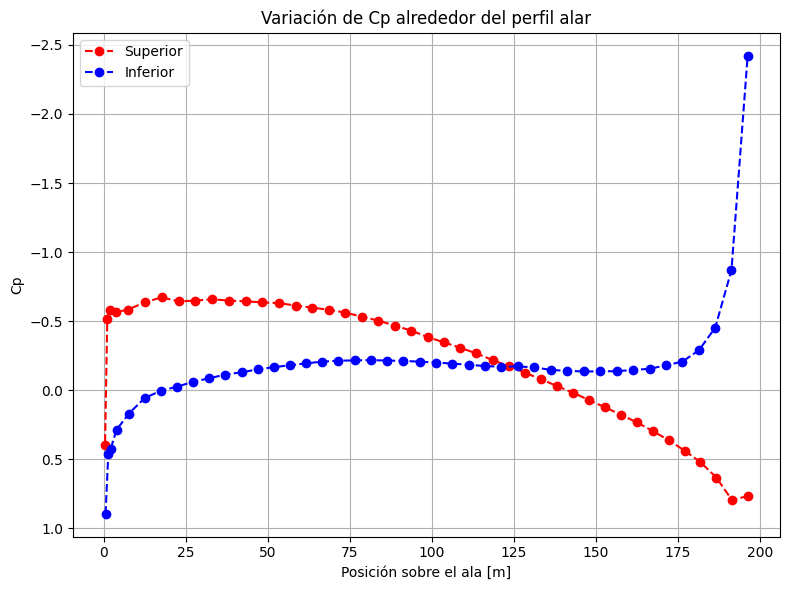

In [ ]:
test.plot_cp_airfoil()

In [ ]:
cp_under = np.sum(test.pressure[test.lower_elements])
cp_above = np.sum(test.pressure[test.upper_elements])
print(f'Coeficiente de presión total sobre el ala: {cp_above} [-]')
print(f'Coeficiente de presión total bajo el ala: {cp_under} [-]')

Coeficiente de presión total sobre el ala: -11.64737917478655 [-]
Coeficiente de presión total bajo el ala: -14.92934624894647 [-]


In [ ]:
test.lift

np.float64(1057.6343388482371)